# Лабораторная работа №5. Автокорреляция
## Жилкина Лада, 5130901/10202

In [37]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../')
from thinkdsp import read_wave, decorate, Wave

## Упраженение 5.1
Пример кода в упражнении 5.1 показывает, как использовать автокорреляцию для оценки основной частоты периодического сигнала. Оценим высоты тона вокального чирпа для нескольких времен начала сегмента.

In [38]:
def serial_corr(wave, lag=1):
    """Computes serial correlation with given lag.

    wave: Wave
    lag: integer, how much to shift the wave

    returns: float correlation coefficient
    """
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

In [39]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [40]:
wave = read_wave('marcgascon7_vocals.wav')
wave.make_audio()

In [41]:
wave1 = wave.segment(start = 3, duration = 1) 
wave1.make_audio()

In [42]:
wave2 = wave.segment(start = 5, duration = 1) 
wave2.make_audio()

Вычислим автокорреляцию сначала звука "И", а потом звука "О".

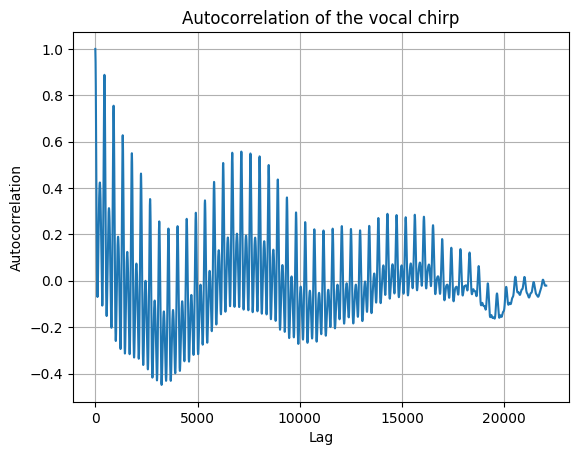

In [43]:
lags, corrs = autocorr(wave1)
plt.plot(lags, corrs)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the vocal chirp')
plt.grid(True)
plt.show()

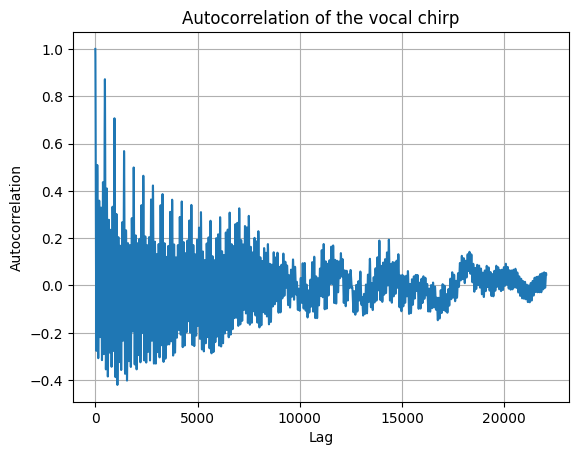

In [44]:
lags1, corrs1 = autocorr(wave2)
plt.plot(lags1, corrs1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the vocal chirp')
plt.grid(True)
plt.show()

Для примеров были взяты звуки "И" и "О". Видно, что на графике со звуком "И" представлена звуковая волна, в кторой частота постепенно изменяется с течением времени. Такое может произойти при произнесении определенных звуков, когда человеческие голосовые связки переходят от одного резонансного состояния к другому. На графике со звуком "О" этого не видно.

## Упражнение 5.2
Инкапсулируем код из chap05.ipynb в функцию estimate_funsamential.

In [45]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Распечатаем спектрограмму записанного звука.

In [46]:
wave = read_wave('bcjordan_voicedownbew.wav')
wave.normalize()
wave.make_audio()

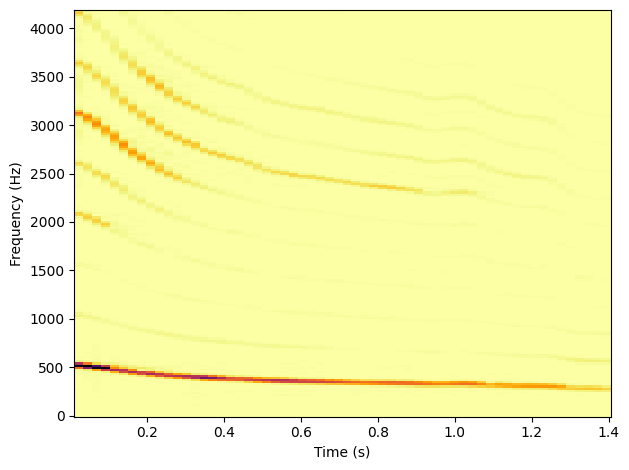

In [47]:
wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)', 
         ylabel='Frequency (Hz)')

Используем функцию estimate_value для оценки высоты записанного звука.

In [48]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

Наложим оценки высоты тона на спектрограмму, полученную ранее.

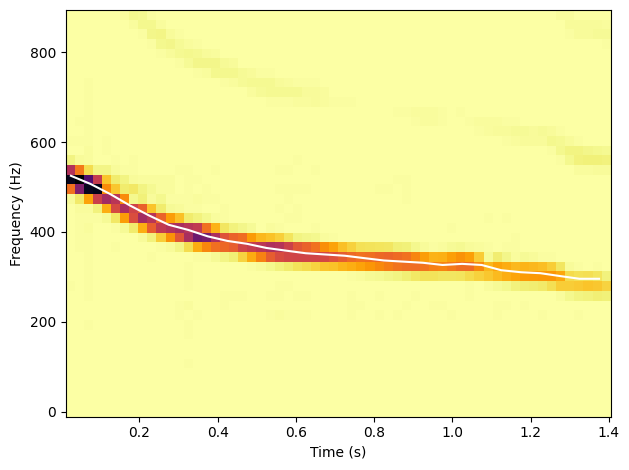

In [49]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

## Упражнение 5.3
Используя данные о цене биткоина из прошлой лабораторной работы, вычилим автокорелляции цен в платёжной системе.

C:\Users\zhilk\AppData\Local\Temp\ipykernel_7392\1024235611.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../lab4/BTC-Daily.csv', parse_dates=[0])


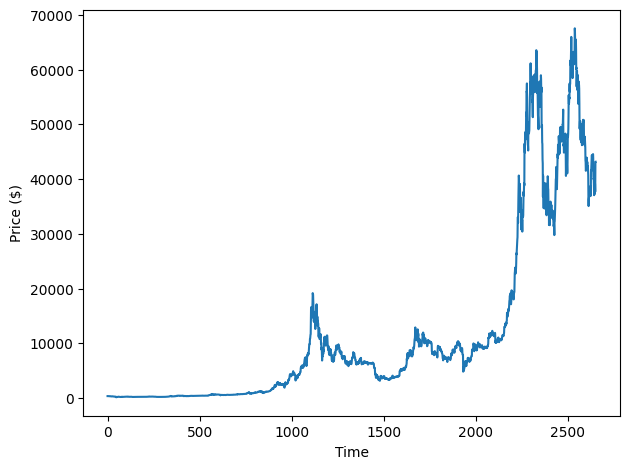

In [50]:
df = pd.read_csv('../lab4/BTC-Daily.csv', parse_dates=[0])

ys = df['close']
ys = np.flip(ys)
ts = df.index
wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time', ylabel='Price ($)')

Используя функции serial_corr и autocorr, получим график автокорреляции.

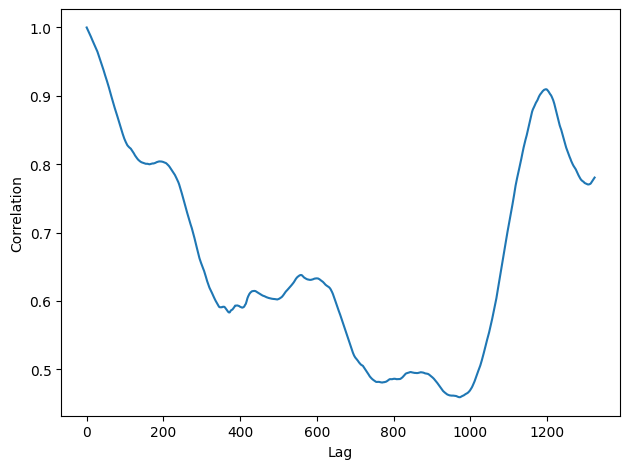

In [51]:
result = autocorr(wave)
lags, corrs = result
plt.plot(lags, corrs)
decorate(xlabel='Lag', ylabel='Correlation')

Теперь вычислим корреляцию на основе функции np.correlate. Она не смещает и не нормализует волну.

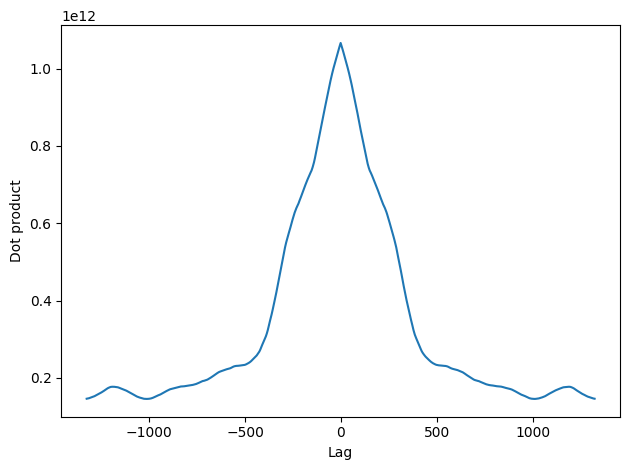

In [52]:
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-len(wave) // 2, len(wave) // 2) 
plt.plot(lags, corrs2)
decorate(xlabel='Lag', ylabel='Dot product')

Вторая половина результатов соответствует интервалам задержек с положительными значениями. Рассмотрим ее подробнее, чтобы сравнить две функции.

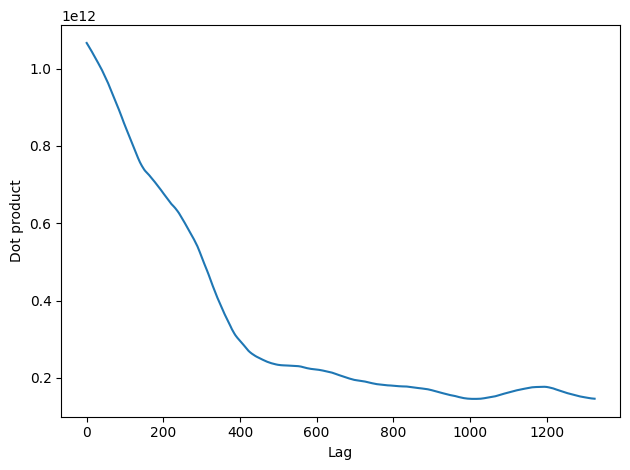

In [53]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate(xlabel='Lag', ylabel='Dot product')

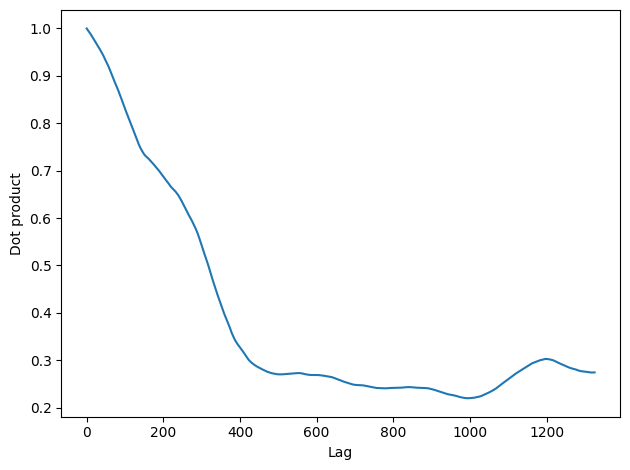

In [54]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag', ylabel='Dot product')

Сравним функции.

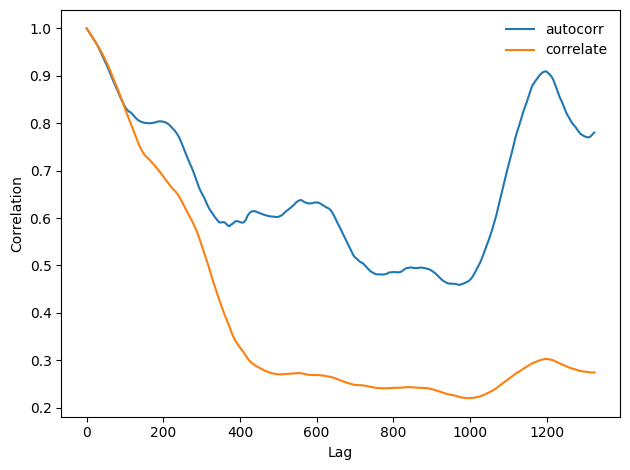

In [56]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate(xlabel='Lag', ylabel='Correlation')

Функция autocorr более точная, чем функция correlate. Признаков периодичности в данном примере нет. Автокорреляционная функция спадает постепенно, потом резко растёт.